<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-05-19 17:32:30--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-05-19 17:32:30 (231 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

### Convert to date time object


In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


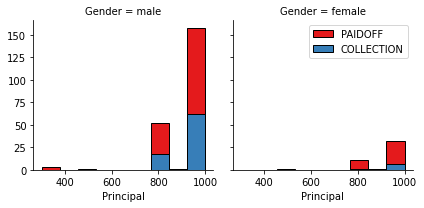

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

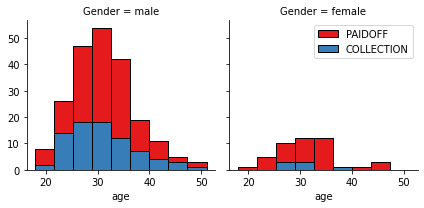

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


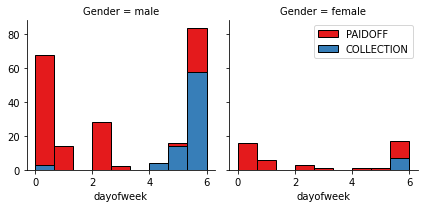

In [ ]:
#we created day of the week column here


df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## One Hot Encoding

#### How about education?


#### Feature befor One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [ ]:
y= df['loan_status'].map({'PAIDOFF': 1, 'COLLECTION': 0})
y


0      1
1      1
2      1
3      1
4      1
      ..
341    0
342    0
343    0
344    0
345    0
Name: loan_status, Length: 346, dtype: int64

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
yhat = neigh.predict(X_test)
yhat[0:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train))) 
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


In [ ]:
k5 = 5
#Train Model  
neigh5 = KNeighborsClassifier(n_neighbors = k5).fit(X_train,y_train)

# Predict 
yhat = neigh5.predict(X_test)
yhat[0:10]

#Find accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh5.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.7571428571428571


In [ ]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

In [ ]:
print( "From these k accuracy scores, the most accurate k value is k=7 with .78 or 78% accuracy")

From these k accuracy scores, the most accurate k value is k=7 with .78 or 78% accuracy


In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, average='weighted')


0.628921078921079

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7468745610338531

# Decision Tree


In [ ]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)
print('y trainset:', y_trainset.shape)
print('x trainset:', X_trainset.shape)
print('y testset:', y_testset.shape)
print('x testset:', X_testset.shape)


y trainset: (276,)
x trainset: (276, 8)
y testset: (70,)
x testset: (70, 8)


In [ ]:
#Model building and training
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree

#Model Training
loanTree.fit(X_train, y_train)

#Model prediction
predTree= loanTree.predict(X_test)
print(predTree[0:5])
print(y_testset [0:5])

[0 0 1 1 1]
73     1
24     1
282    0
295    0
163    1
Name: loan_status, dtype: int64


In [ ]:
#Model Evaluation
print("DecisionTrees's Accuracyfor test set: ", metrics.accuracy_score(y_testset, predTree))
print("DecisionTrees's Accuracy for train set: ", metrics.accuracy_score(y_trainset, loanTree.predict(X_trainset)))


DecisionTrees's Accuracyfor test set:  0.4714285714285714
DecisionTrees's Accuracy for train set:  0.7355072463768116


In [ ]:
jaccard_score(y_testset, predTree, average='weighted')

0.32910610465116275

In [ ]:
f1_score(y_testset, predTree, average='weighted') 

0.4788966135904911

# Support Vector Machine


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [ ]:
from sklearn import svm
#model building
clf = svm.SVC(kernel='rbf')

#model training
clf.fit(X_train, y_train) 

#model predicting
yhat=clf.predict(X_test)
yhat[0:5]

array([0, 1, 1, 1, 1])

In [ ]:

#Model Evaluation
print("svm's Accuracyfor test set: ", metrics.accuracy_score(y_test, yhat))
print("svm's Accuracy for train set: ", metrics.accuracy_score(y_train, loanTree.predict(X_train)))


svm's Accuracyfor test set:  0.7428571428571429
svm's Accuracy for train set:  0.7463768115942029


In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, average='weighted')


0.6103896103896104

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7275882012724117

# Logistic Regression


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [ ]:
#model building
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear')
LR

#model training
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

#model predicting
yhat=LR.predict(X_test)
print(yhat)

#probability of predicting  each customer in X_test
yhat_prob=LR.predict_proba(X_test)
print(yhat_prob)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
[[0.5034238  0.4965762 ]
 [0.45206111 0.54793889]
 [0.30814132 0.69185868]
 [0.34259428 0.65740572]
 [0.32025894 0.67974106]
 [0.31680537 0.68319463]
 [0.48830185 0.51169815]
 [0.47823073 0.52176927]
 [0.34259428 0.65740572]
 [0.4934056  0.5065944 ]
 [0.33806706 0.66193294]
 [0.49662231 0.50337769]
 [0.24891907 0.75108093]
 [0.3419095  0.6580905 ]
 [0.43751789 0.56248211]
 [0.25760497 0.74239503]
 [0.52357188 0.47642812]
 [0.30450278 0.69549722]
 [0.50166363 0.49833637]
 [0.3195971  0.6804029 ]
 [0.44276988 0.55723012]
 [0.49410185 0.50589815]
 [0.51350333 0.48649667]
 [0.47203498 0.52796502]
 [0.40944694 0.59055306]
 [0.50846442 0.49153558]
 [0.51098415 0.48901585]
 [0.37457647 0.62542353]
 [0.50418423 0.49581577]
 [0.25299635 0.74700365]
 [0.46824113 0.53175887]
 [0.46024688 0.53975312]
 [0.46206917 0.53793083]
 [0.48402425 0.51597575]
 [0.388

In [ ]:

#Model Evaluation
print("Logistic regression's Accuracy for test set: ", metrics.accuracy_score(y_test, yhat))
print("Logistic regression's Accuracy for train set: ", metrics.accuracy_score(y_train, LR.predict(X_train)))

Logistic regression's Accuracy for test set:  0.6857142857142857
Logistic regression's Accuracy for train set:  0.7572463768115942


In [ ]:
jaccard_score(y_test, yhat, average='weighted')

0.5493697478991597

In [ ]:
f1_score(y_test, yhat, average='weighted') 

0.6670522459996144

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5772287609479654

# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-05-19 16:52:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-05-19 16:52:29 (664 MB/s) - ‘loan_test.csv’ saved [3642/3642]



# Evaluation Solution

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | .629       | .747    | NA      |
| Decision Tree      | .329       | .479       | NA      |
| SVM                | .610      | .768        | NA      |
| LogisticRegression | .549      | .667        | .577    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
